In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

import time
import matplotlib.pyplot as plt
import numpy as np

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Discriminator & Generator

In [2]:
def Discriminator(input_shape=[28,28,1], n_classes=10, filters=32):
    # input label (Embedding layers)
    input_label = layers.Input(shape=[1])
    em_block = layers.Embedding(n_classes, 64)(input_label)
    em_block = layers.Dense(input_shape[0]*input_shape[1])(em_block)
    em_block = layers.Reshape(input_shape)(em_block)
    
    # convolutional layers
    input_img = layers.Input(shape=input_shape)
    ## merge label and image
    merge = layers.Concatenate()([input_img, em_block])
    
    ## convolutional block 1
    conv_1 = layers.Conv2D(filters, 3, padding='same')(merge)
    conv_1 = layers.BatchNormalization()(conv_1)
    conv_1 = layers.ReLU()(conv_1)
    conv_1 = layers.Dropout(0.3)(conv_1)
    conv_1 = layers.MaxPooling2D()(conv_1)
    
    ## convolutional block 2
    conv_2 = layers.Conv2D(filters * 2, 3, padding='same')(conv_1)
    conv_2 = layers.BatchNormalization()(conv_2)
    conv_2 = layers.ReLU()(conv_2)
    conv_2 = layers.Dropout(0.3)(conv_2)
    conv_2 = layers.MaxPooling2D()(conv_2)
    
    ## convolutional block 3
    conv_3 = layers.Conv2D(filters * 4, 3, padding='same')(conv_2)
    conv_3 = layers.BatchNormalization()(conv_3)
    conv_3 = layers.ReLU()(conv_3)
    conv_3 = layers.Dropout(0.3)(conv_3)
    conv_3 = layers.MaxPooling2D()(conv_3)
    
    flat = layers.Flatten()(conv_3)
    
    out = layers.Dense(128)(flat)
    out = layers.ReLU()(out)
    out = layers.Dropout(0.3)(out)
    out = layers.Dense(1)(out)
    
    return models.Model([input_label, input_img], out)

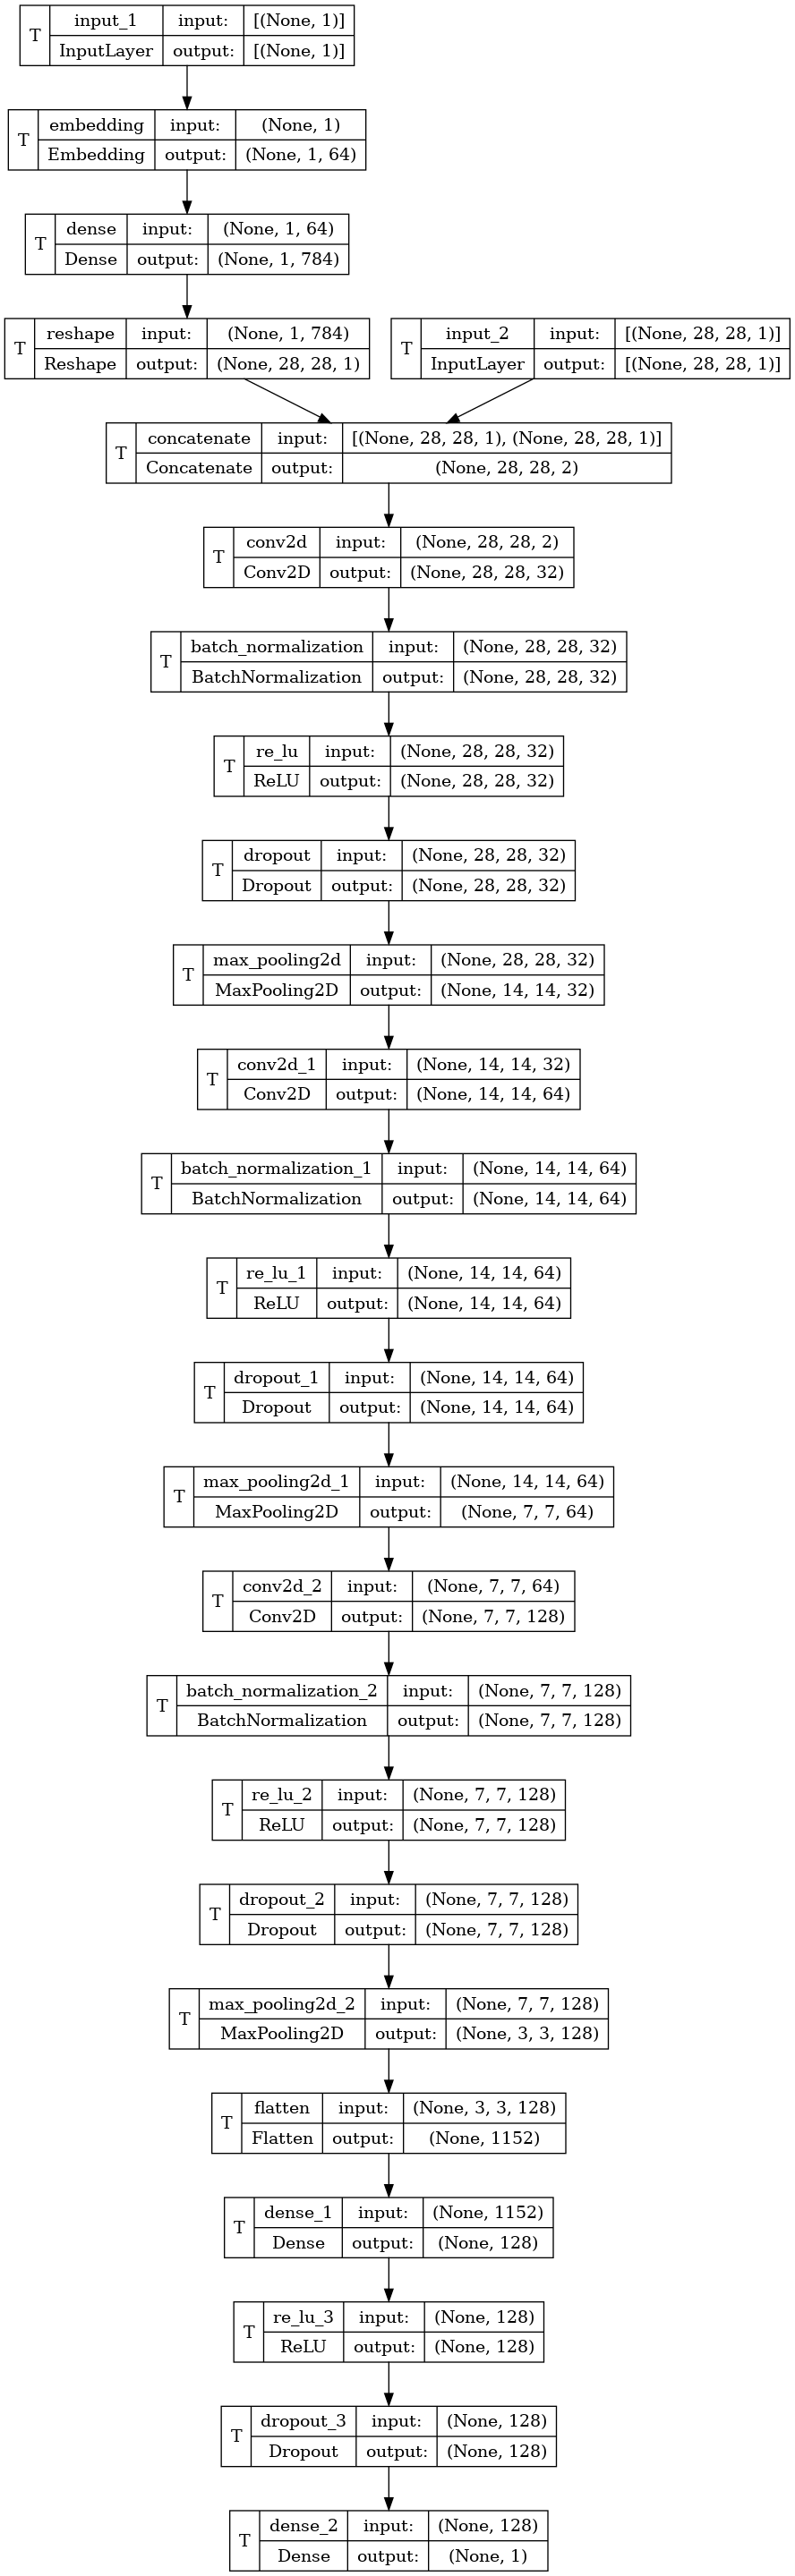

In [3]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, show_trainable=True)

In [4]:
LATENT_DIM = 256

In [5]:
def Generator(latent_dim, n_classes=10):
    # input label (Embedding layers)
    input_label = layers.Input(shape=[1])
    em_block = layers.Embedding(n_classes, 64)(input_label)
    em_block = layers.Dense(7*7)(em_block)
    em_block = layers.Reshape([7, 7, 1])(em_block)
    
    # input noise
    input_latent = layers.Input(shape=[latent_dim])
    
    full_c = layers.Dense(7*7*latent_dim)(input_latent)
    full_c = layers.LeakyReLU()(full_c)
    full_c = layers.Reshape([7, 7, latent_dim])(full_c)
    
    # merge label and latent
    merge = layers.Concatenate()([em_block, full_c])
    
    # convolutional transpose block 1
    conv_trans_1 = layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False)(merge)
    conv_trans_1 = layers.BatchNormalization()(conv_trans_1)
    conv_trans_1 = layers.LeakyReLU()(conv_trans_1)
    
    # convolutional transpose block 2
    conv_trans_2 = layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False)(conv_trans_1)
    conv_trans_2 = layers.BatchNormalization()(conv_trans_2)
    conv_trans_2 = layers.LeakyReLU()(conv_trans_2)
    
    # output
    out = layers.Conv2D(1, (5,5), activation='tanh', padding='same')(conv_trans_2)
    
    return models.Model([input_label, input_latent], out)
    

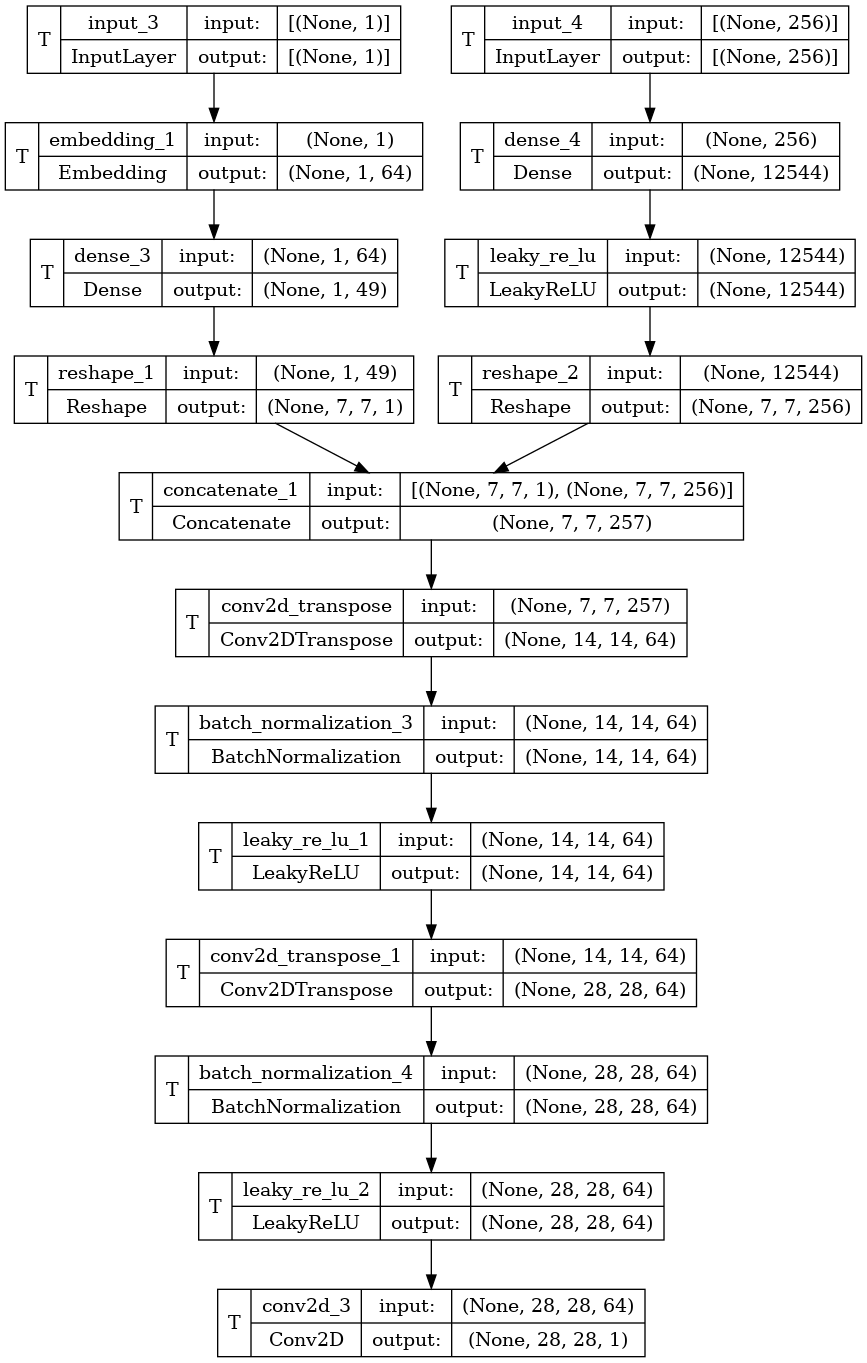

In [6]:
generator = Generator(LATENT_DIM)
tf.keras.utils.plot_model(generator, show_shapes=True, show_trainable=True)

# Loss & Optimizer

In [7]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [8]:
def generator_loss(fake_prediction):
    return cross_entropy(tf.ones_like(fake_prediction), fake_prediction)

def discriminator_loss(real_prediction, fake_prediction):
    real_loss = cross_entropy(tf.ones_like(real_prediction), real_prediction)
    fake_loss = cross_entropy(tf.zeros_like(fake_prediction), fake_prediction)
    total_loss = real_loss + fake_loss
    return total_loss

In [9]:
generator_optimizer = tf.keras.optimizers.Adam(2e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

# Training loop

In [10]:
@tf.function
def train_step(images, labels):
    noise = tf.random.normal([images.shape[0], LATENT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([labels, noise], training=True)

        real_output = discriminator([labels, images], training=True)
        fake_output = discriminator([labels, generated_images], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return {"generator_loss": gen_loss, "discriminator_loss": disc_loss}

In [11]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        seed = tf.random.normal([16, LATENT_DIM])
        label = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5])

        for image_batch, label_batch in dataset:
            train_step(image_batch, label_batch)

        # Save the model every 10 epochs
        if (epoch + 1) % 10 == 0:
            # Produce images for the GIF as you go
            generate_images(generator, epoch + 1, seed, label)
            # checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

    # Generate after the final epoch
    generate_images(generator, epochs, seed, label)

def generate_images(model, epoch, test_input, test_label):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model([test_label, test_input], training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# Data

In [12]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = (x_train-127.5)/127.5, (x_test-127.5)/127.5

x_train = np.concatenate([x_train, x_test])
y_train = np.concatenate([y_train, y_test])

11490434/11490434 [==============================] - 0s 0us/step


In [13]:
BUFFER_SIZE = 123456
BATCH_SIZE = 512

In [14]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE)

# Train

2023-08-28 12:33:20.922394: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-08-28 12:33:43.107975: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Time for epoch 1 is 26.92896294593811 sec
Time for epoch 2 is 9.808329582214355 sec
Time for epoch 3 is 9.835796117782593 sec
Time for epoch 4 is 9.895406484603882 sec
Time for epoch 5 is 9.825170278549194 sec
Time for epoch 6 is 9.826329708099365 sec
Time for epoch 7 is 9.835797548294067 sec
Time for epoch 8 is 9.889375448226929 sec
Time for epoch 9 is 9.827256202697754 sec


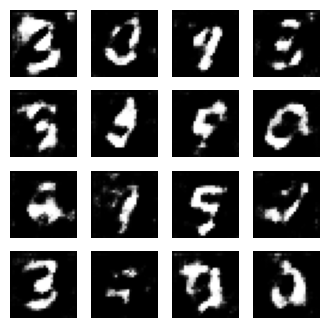

Time for epoch 10 is 10.457239389419556 sec
Time for epoch 11 is 9.926017045974731 sec
Time for epoch 12 is 9.88440489768982 sec
Time for epoch 13 is 9.85546088218689 sec
Time for epoch 14 is 9.896636486053467 sec
Time for epoch 15 is 9.842198610305786 sec
Time for epoch 16 is 9.798981666564941 sec
Time for epoch 17 is 9.882115364074707 sec
Time for epoch 18 is 9.853182792663574 sec
Time for epoch 19 is 9.835468292236328 sec


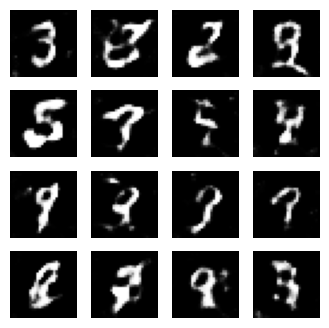

Time for epoch 20 is 10.395236730575562 sec
Time for epoch 21 is 9.832637071609497 sec
Time for epoch 22 is 9.846370458602905 sec
Time for epoch 23 is 9.824772596359253 sec
Time for epoch 24 is 9.878254413604736 sec
Time for epoch 25 is 9.836085796356201 sec
Time for epoch 26 is 9.84923505783081 sec
Time for epoch 27 is 9.890657901763916 sec
Time for epoch 28 is 9.832772254943848 sec
Time for epoch 29 is 9.833897590637207 sec


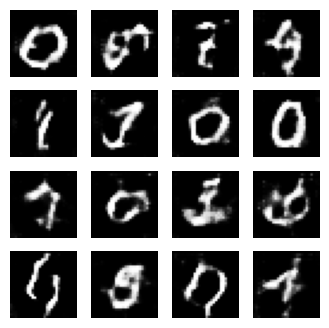

Time for epoch 30 is 10.686611413955688 sec
Time for epoch 31 is 9.845731019973755 sec
Time for epoch 32 is 9.820534944534302 sec
Time for epoch 33 is 9.881223201751709 sec
Time for epoch 34 is 9.829357862472534 sec
Time for epoch 35 is 9.838415622711182 sec
Time for epoch 36 is 9.88990592956543 sec
Time for epoch 37 is 9.821947574615479 sec
Time for epoch 38 is 9.85064697265625 sec
Time for epoch 39 is 9.832304000854492 sec


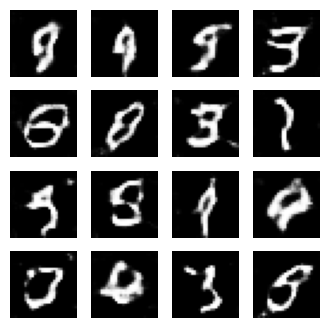

Time for epoch 40 is 10.432673454284668 sec
Time for epoch 41 is 9.82642412185669 sec
Time for epoch 42 is 9.834038019180298 sec
Time for epoch 43 is 9.867468118667603 sec
Time for epoch 44 is 9.802718162536621 sec
Time for epoch 45 is 9.864495754241943 sec
Time for epoch 46 is 9.867380619049072 sec
Time for epoch 47 is 9.819105386734009 sec
Time for epoch 48 is 9.85292100906372 sec
Time for epoch 49 is 9.884787321090698 sec


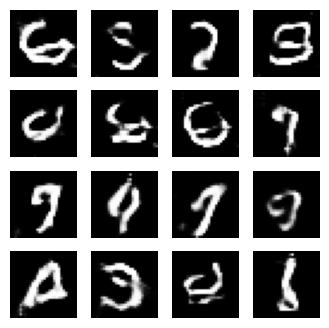

Time for epoch 50 is 10.402279376983643 sec
Time for epoch 51 is 9.852636575698853 sec
Time for epoch 52 is 9.887656688690186 sec
Time for epoch 53 is 9.83901572227478 sec
Time for epoch 54 is 9.838392734527588 sec
Time for epoch 55 is 9.79539942741394 sec
Time for epoch 56 is 9.929837226867676 sec
Time for epoch 57 is 9.830803155899048 sec
Time for epoch 58 is 9.83058500289917 sec
Time for epoch 59 is 9.874765157699585 sec


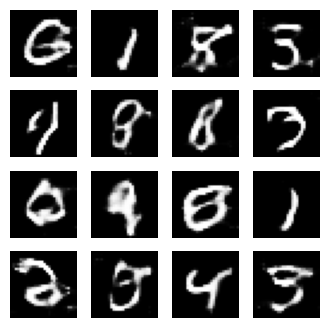

Time for epoch 60 is 10.383118152618408 sec
Time for epoch 61 is 9.832767486572266 sec
Time for epoch 62 is 9.860982656478882 sec
Time for epoch 63 is 9.830709457397461 sec
Time for epoch 64 is 9.827612161636353 sec
Time for epoch 65 is 9.899954319000244 sec
Time for epoch 66 is 9.833928108215332 sec
Time for epoch 67 is 9.83187198638916 sec
Time for epoch 68 is 9.852983474731445 sec
Time for epoch 69 is 9.828062057495117 sec


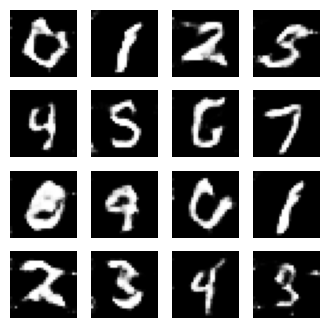

Time for epoch 70 is 10.385071039199829 sec
Time for epoch 71 is 9.818156719207764 sec
Time for epoch 72 is 9.896307468414307 sec
Time for epoch 73 is 9.79907488822937 sec
Time for epoch 74 is 9.908805131912231 sec
Time for epoch 75 is 9.87147331237793 sec
Time for epoch 76 is 9.842067956924438 sec
Time for epoch 77 is 9.839132070541382 sec
Time for epoch 78 is 9.85282850265503 sec
Time for epoch 79 is 9.831719636917114 sec


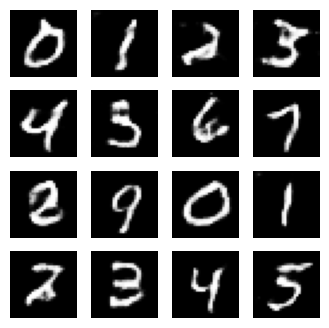

Time for epoch 80 is 10.651529550552368 sec
Time for epoch 81 is 9.87400770187378 sec
Time for epoch 82 is 9.854283332824707 sec
Time for epoch 83 is 9.820915937423706 sec
Time for epoch 84 is 9.86384129524231 sec
Time for epoch 85 is 9.845802307128906 sec
Time for epoch 86 is 9.879411697387695 sec
Time for epoch 87 is 9.870437622070312 sec
Time for epoch 88 is 9.882559061050415 sec
Time for epoch 89 is 9.899982213973999 sec


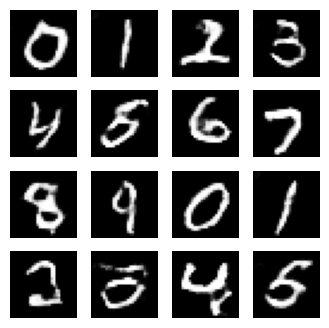

Time for epoch 90 is 10.372243881225586 sec
Time for epoch 91 is 9.865886449813843 sec
Time for epoch 92 is 9.833105564117432 sec
Time for epoch 93 is 9.834938526153564 sec
Time for epoch 94 is 9.845771789550781 sec
Time for epoch 95 is 9.840784072875977 sec
Time for epoch 96 is 9.817002296447754 sec
Time for epoch 97 is 9.872788667678833 sec
Time for epoch 98 is 9.823704719543457 sec
Time for epoch 99 is 9.82021188735962 sec


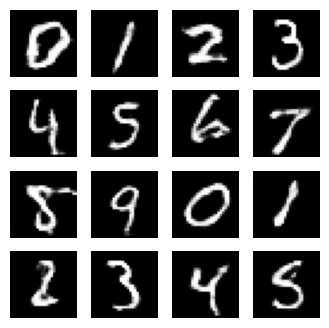

Time for epoch 100 is 10.4673433303833 sec
Time for epoch 101 is 9.853631019592285 sec
Time for epoch 102 is 9.84088683128357 sec
Time for epoch 103 is 9.821973085403442 sec
Time for epoch 104 is 9.881094217300415 sec
Time for epoch 105 is 9.823666095733643 sec
Time for epoch 106 is 9.840969324111938 sec
Time for epoch 107 is 9.855401277542114 sec
Time for epoch 108 is 9.837543964385986 sec
Time for epoch 109 is 9.823544025421143 sec


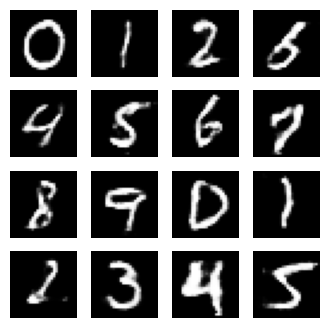

Time for epoch 110 is 10.392176866531372 sec
Time for epoch 111 is 9.829368591308594 sec
Time for epoch 112 is 9.804656267166138 sec
Time for epoch 113 is 9.866788864135742 sec
Time for epoch 114 is 9.819234371185303 sec
Time for epoch 115 is 9.836911678314209 sec
Time for epoch 116 is 9.836035251617432 sec
Time for epoch 117 is 9.859627723693848 sec
Time for epoch 118 is 9.814607620239258 sec
Time for epoch 119 is 9.813724756240845 sec


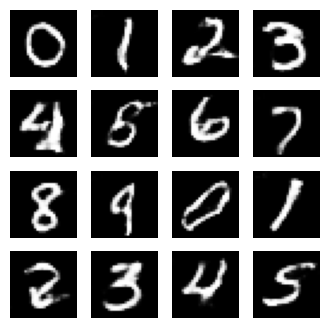

Time for epoch 120 is 10.34138798713684 sec
Time for epoch 121 is 9.83075761795044 sec
Time for epoch 122 is 9.838303327560425 sec
Time for epoch 123 is 9.804666757583618 sec
Time for epoch 124 is 9.845339059829712 sec
Time for epoch 125 is 9.820098876953125 sec
Time for epoch 126 is 9.86561918258667 sec
Time for epoch 127 is 9.812116622924805 sec
Time for epoch 128 is 9.80955195426941 sec
Time for epoch 129 is 9.829623937606812 sec


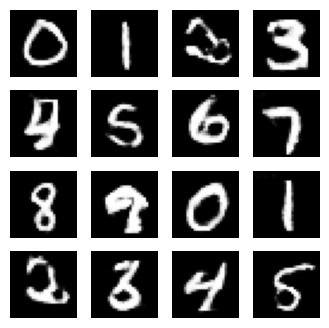

Time for epoch 130 is 10.655367136001587 sec
Time for epoch 131 is 9.824363231658936 sec
Time for epoch 132 is 9.817696332931519 sec
Time for epoch 133 is 9.841134071350098 sec
Time for epoch 134 is 9.856530666351318 sec
Time for epoch 135 is 9.817880868911743 sec
Time for epoch 136 is 9.860787153244019 sec
Time for epoch 137 is 9.82582974433899 sec
Time for epoch 138 is 9.833011150360107 sec
Time for epoch 139 is 9.86167287826538 sec


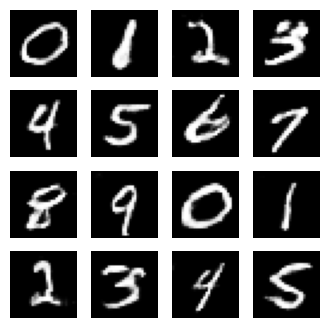

Time for epoch 140 is 10.365247011184692 sec
Time for epoch 141 is 9.812339305877686 sec
Time for epoch 142 is 9.870532035827637 sec
Time for epoch 143 is 9.811620235443115 sec
Time for epoch 144 is 9.82807183265686 sec
Time for epoch 145 is 9.894217252731323 sec
Time for epoch 146 is 9.832350015640259 sec
Time for epoch 147 is 9.824809312820435 sec
Time for epoch 148 is 9.807221412658691 sec
Time for epoch 149 is 9.881824254989624 sec


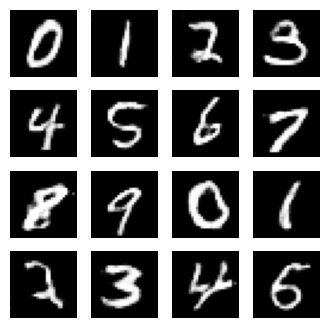

Time for epoch 150 is 10.322247743606567 sec
Time for epoch 151 is 9.806229591369629 sec
Time for epoch 152 is 9.832592964172363 sec
Time for epoch 153 is 9.805824041366577 sec
Time for epoch 154 is 9.808507442474365 sec
Time for epoch 155 is 9.85847806930542 sec
Time for epoch 156 is 9.818331480026245 sec
Time for epoch 157 is 9.800055742263794 sec
Time for epoch 158 is 9.89977765083313 sec
Time for epoch 159 is 9.818220376968384 sec


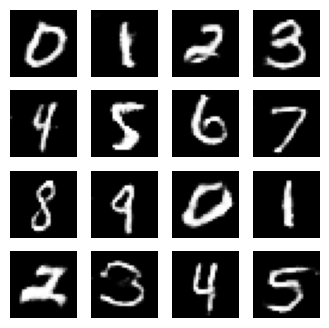

Time for epoch 160 is 10.327096939086914 sec
Time for epoch 161 is 9.855653762817383 sec
Time for epoch 162 is 9.805518865585327 sec
Time for epoch 163 is 9.84857439994812 sec
Time for epoch 164 is 9.825600862503052 sec
Time for epoch 165 is 9.874765634536743 sec
Time for epoch 166 is 9.841799259185791 sec
Time for epoch 167 is 9.823998212814331 sec
Time for epoch 168 is 9.861259460449219 sec
Time for epoch 169 is 9.842288732528687 sec


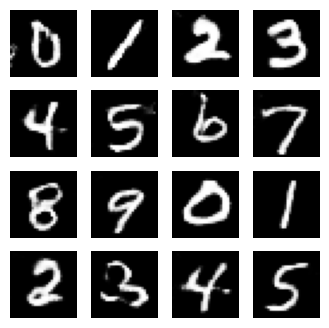

Time for epoch 170 is 10.343377351760864 sec
Time for epoch 171 is 9.864313125610352 sec
Time for epoch 172 is 9.813921928405762 sec
Time for epoch 173 is 9.815514326095581 sec
Time for epoch 174 is 9.853152990341187 sec
Time for epoch 175 is 9.813984394073486 sec
Time for epoch 176 is 9.8249831199646 sec
Time for epoch 177 is 9.829320430755615 sec
Time for epoch 178 is 9.837581872940063 sec
Time for epoch 179 is 9.834295272827148 sec


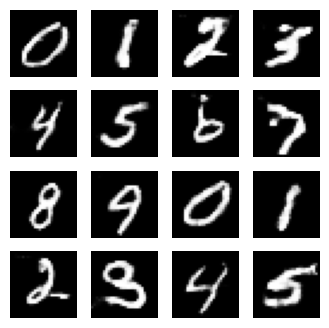

Time for epoch 180 is 10.738846778869629 sec
Time for epoch 181 is 9.870766162872314 sec
Time for epoch 182 is 9.848788738250732 sec
Time for epoch 183 is 9.79602575302124 sec
Time for epoch 184 is 9.880473136901855 sec
Time for epoch 185 is 9.825047254562378 sec
Time for epoch 186 is 9.832563877105713 sec
Time for epoch 187 is 9.87778902053833 sec
Time for epoch 188 is 9.83629822731018 sec
Time for epoch 189 is 9.819073915481567 sec


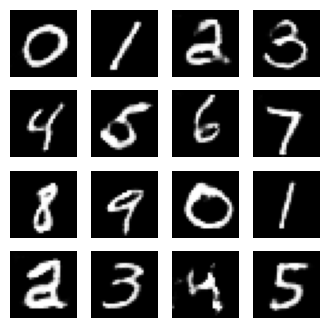

Time for epoch 190 is 10.39567232131958 sec
Time for epoch 191 is 9.819818258285522 sec
Time for epoch 192 is 9.834389925003052 sec
Time for epoch 193 is 9.844176530838013 sec
Time for epoch 194 is 9.867667436599731 sec
Time for epoch 195 is 9.825992345809937 sec
Time for epoch 196 is 9.838951349258423 sec
Time for epoch 197 is 9.864780187606812 sec
Time for epoch 198 is 9.827522277832031 sec
Time for epoch 199 is 9.824357509613037 sec


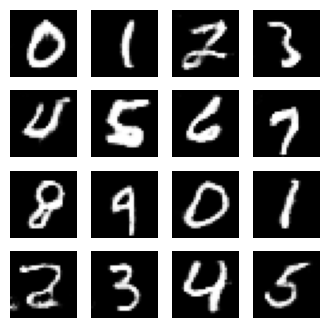

Time for epoch 200 is 10.356122255325317 sec
Time for epoch 201 is 9.837796688079834 sec
Time for epoch 202 is 9.832883834838867 sec
Time for epoch 203 is 9.849811553955078 sec
Time for epoch 204 is 9.79580307006836 sec
Time for epoch 205 is 9.812032699584961 sec
Time for epoch 206 is 9.93857479095459 sec
Time for epoch 207 is 9.82010555267334 sec
Time for epoch 208 is 9.847776889801025 sec
Time for epoch 209 is 9.81475043296814 sec


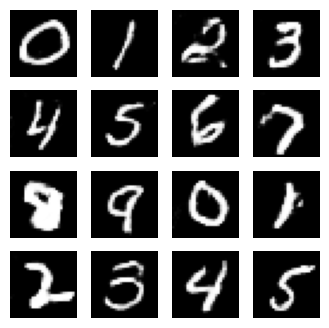

Time for epoch 210 is 10.372249126434326 sec
Time for epoch 211 is 9.829395532608032 sec
Time for epoch 212 is 9.830517053604126 sec
Time for epoch 213 is 9.85469913482666 sec
Time for epoch 214 is 9.8469979763031 sec
Time for epoch 215 is 9.828376531600952 sec
Time for epoch 216 is 9.828040599822998 sec
Time for epoch 217 is 9.868419408798218 sec
Time for epoch 218 is 9.831079483032227 sec
Time for epoch 219 is 9.850141525268555 sec


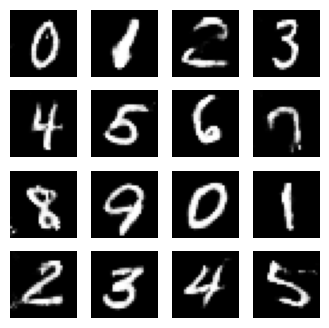

Time for epoch 220 is 10.393277883529663 sec
Time for epoch 221 is 9.828878164291382 sec
Time for epoch 222 is 9.900586366653442 sec
Time for epoch 223 is 9.808790683746338 sec
Time for epoch 224 is 9.864935159683228 sec
Time for epoch 225 is 9.827223062515259 sec
Time for epoch 226 is 9.89250898361206 sec
Time for epoch 227 is 9.834902286529541 sec
Time for epoch 228 is 9.82611894607544 sec
Time for epoch 229 is 9.88526177406311 sec


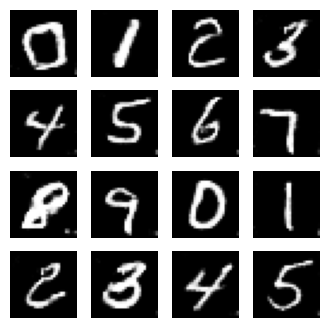

Time for epoch 230 is 10.667948961257935 sec
Time for epoch 231 is 9.868946552276611 sec
Time for epoch 232 is 9.83804702758789 sec
Time for epoch 233 is 9.841852188110352 sec
Time for epoch 234 is 9.831646203994751 sec
Time for epoch 235 is 9.84778618812561 sec
Time for epoch 236 is 9.84134554862976 sec
Time for epoch 237 is 9.803353309631348 sec
Time for epoch 238 is 9.865130424499512 sec
Time for epoch 239 is 9.823944568634033 sec


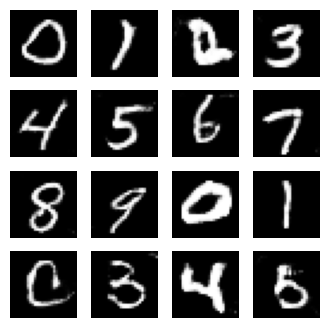

Time for epoch 240 is 10.402101278305054 sec
Time for epoch 241 is 9.831142663955688 sec
Time for epoch 242 is 9.865467548370361 sec
Time for epoch 243 is 9.858640670776367 sec
Time for epoch 244 is 9.823072910308838 sec
Time for epoch 245 is 9.871081590652466 sec
Time for epoch 246 is 9.838408946990967 sec
Time for epoch 247 is 9.827300310134888 sec
Time for epoch 248 is 9.868497133255005 sec
Time for epoch 249 is 9.791266441345215 sec


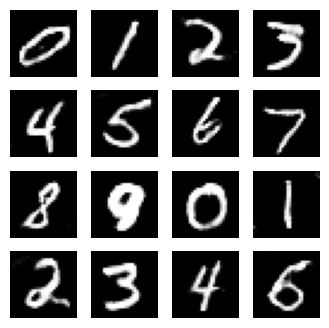

Time for epoch 250 is 10.357916593551636 sec
Time for epoch 251 is 9.866564750671387 sec
Time for epoch 252 is 9.825763463973999 sec
Time for epoch 253 is 9.842149496078491 sec
Time for epoch 254 is 9.91006326675415 sec
Time for epoch 255 is 9.83048939704895 sec
Time for epoch 256 is 9.852912425994873 sec
Time for epoch 257 is 9.847728729248047 sec
Time for epoch 258 is 9.929035425186157 sec
Time for epoch 259 is 9.846706628799438 sec


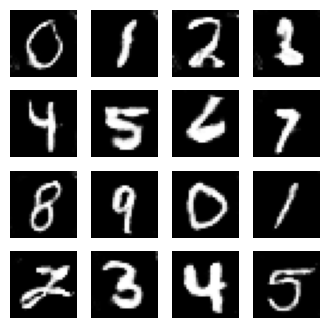

Time for epoch 260 is 10.359445571899414 sec
Time for epoch 261 is 9.87785291671753 sec
Time for epoch 262 is 9.880783796310425 sec
Time for epoch 263 is 9.861542224884033 sec
Time for epoch 264 is 9.858482599258423 sec
Time for epoch 265 is 9.834769010543823 sec
Time for epoch 266 is 9.821749925613403 sec
Time for epoch 267 is 9.880709409713745 sec
Time for epoch 268 is 9.811351537704468 sec
Time for epoch 269 is 9.819884777069092 sec


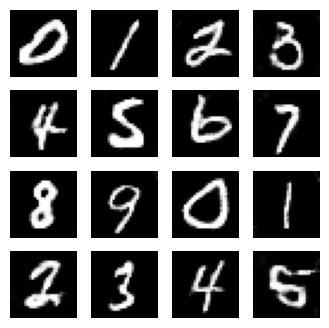

Time for epoch 270 is 10.871715784072876 sec
Time for epoch 271 is 9.824513673782349 sec
Time for epoch 272 is 9.784775257110596 sec
Time for epoch 273 is 9.839076280593872 sec
Time for epoch 274 is 9.873537540435791 sec
Time for epoch 275 is 9.83764123916626 sec
Time for epoch 276 is 9.83267879486084 sec
Time for epoch 277 is 9.881295204162598 sec
Time for epoch 278 is 9.868584871292114 sec
Time for epoch 279 is 9.853848934173584 sec


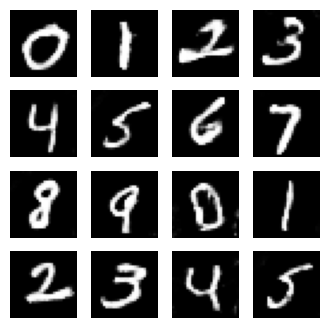

Time for epoch 280 is 10.414592504501343 sec
Time for epoch 281 is 9.86421537399292 sec
Time for epoch 282 is 9.866615533828735 sec
Time for epoch 283 is 9.87780237197876 sec
Time for epoch 284 is 9.829102039337158 sec
Time for epoch 285 is 9.830817937850952 sec
Time for epoch 286 is 9.857176780700684 sec
Time for epoch 287 is 9.842551946640015 sec
Time for epoch 288 is 9.818001508712769 sec
Time for epoch 289 is 9.824692964553833 sec


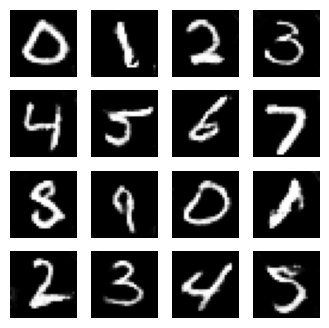

Time for epoch 290 is 10.346126079559326 sec
Time for epoch 291 is 9.819783449172974 sec
Time for epoch 292 is 9.84034276008606 sec
Time for epoch 293 is 9.837226152420044 sec
Time for epoch 294 is 9.814743280410767 sec
Time for epoch 295 is 9.798317909240723 sec
Time for epoch 296 is 9.864617586135864 sec
Time for epoch 297 is 9.824965715408325 sec
Time for epoch 298 is 9.83455204963684 sec
Time for epoch 299 is 9.88967752456665 sec


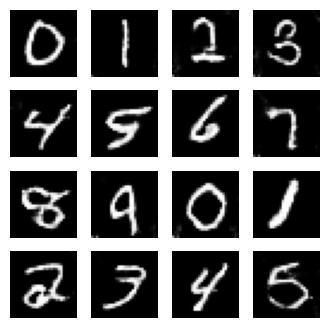

Time for epoch 300 is 10.34920620918274 sec
Time for epoch 301 is 9.850388526916504 sec
Time for epoch 302 is 9.835774660110474 sec
Time for epoch 303 is 9.903935194015503 sec
Time for epoch 304 is 9.846019744873047 sec
Time for epoch 305 is 9.818378925323486 sec
Time for epoch 306 is 9.913037300109863 sec
Time for epoch 307 is 9.841394901275635 sec
Time for epoch 308 is 9.866717338562012 sec
Time for epoch 309 is 9.874945402145386 sec


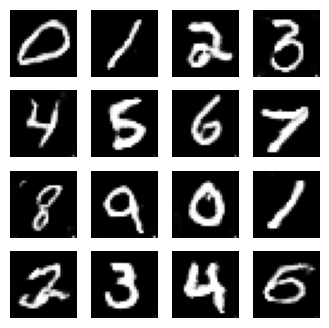

Time for epoch 310 is 10.339953660964966 sec
Time for epoch 311 is 9.814390659332275 sec
Time for epoch 312 is 9.853789329528809 sec
Time for epoch 313 is 9.816988945007324 sec
Time for epoch 314 is 9.837735891342163 sec
Time for epoch 315 is 9.844443321228027 sec
Time for epoch 316 is 9.803701400756836 sec
Time for epoch 317 is 9.819135427474976 sec
Time for epoch 318 is 9.792150497436523 sec
Time for epoch 319 is 9.951216697692871 sec


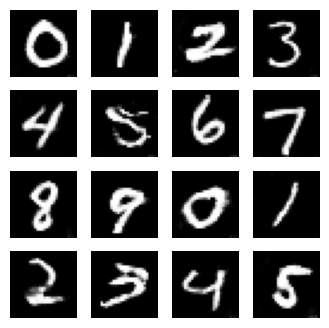

Time for epoch 320 is 10.353401899337769 sec
Time for epoch 321 is 9.801430225372314 sec
Time for epoch 322 is 9.89632248878479 sec
Time for epoch 323 is 9.850637674331665 sec
Time for epoch 324 is 9.83455777168274 sec
Time for epoch 325 is 9.868354320526123 sec
Time for epoch 326 is 9.79190468788147 sec
Time for epoch 327 is 9.876666069030762 sec
Time for epoch 328 is 9.879379987716675 sec
Time for epoch 329 is 9.823244571685791 sec


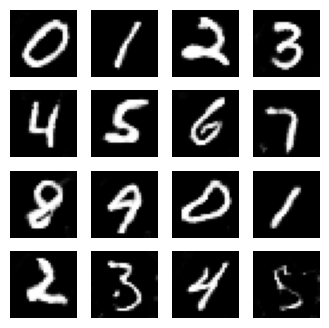

Time for epoch 330 is 10.672038793563843 sec
Time for epoch 331 is 9.838427305221558 sec
Time for epoch 332 is 9.843490362167358 sec
Time for epoch 333 is 9.827654361724854 sec
Time for epoch 334 is 9.823976755142212 sec
Time for epoch 335 is 9.876938819885254 sec
Time for epoch 336 is 9.826951742172241 sec
Time for epoch 337 is 9.829275846481323 sec
Time for epoch 338 is 9.856597661972046 sec
Time for epoch 339 is 9.81710171699524 sec


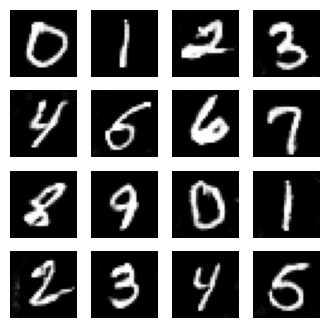

Time for epoch 340 is 10.311388492584229 sec
Time for epoch 341 is 9.877504348754883 sec
Time for epoch 342 is 9.829784393310547 sec
Time for epoch 343 is 9.830107688903809 sec
Time for epoch 344 is 9.896595001220703 sec
Time for epoch 345 is 9.792114734649658 sec
Time for epoch 346 is 9.845691442489624 sec
Time for epoch 347 is 9.870617389678955 sec
Time for epoch 348 is 9.837061166763306 sec
Time for epoch 349 is 9.783184289932251 sec


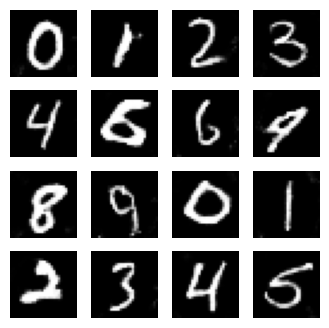

Time for epoch 350 is 10.335824966430664 sec
Time for epoch 351 is 9.881767749786377 sec
Time for epoch 352 is 9.809866666793823 sec
Time for epoch 353 is 9.807372331619263 sec
Time for epoch 354 is 9.84978723526001 sec
Time for epoch 355 is 9.816496849060059 sec
Time for epoch 356 is 9.840883255004883 sec
Time for epoch 357 is 9.851081848144531 sec
Time for epoch 358 is 9.831835746765137 sec
Time for epoch 359 is 9.800825595855713 sec


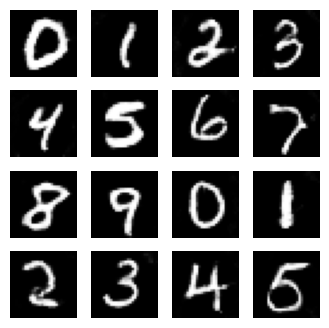

Time for epoch 360 is 10.36596131324768 sec
Time for epoch 361 is 9.804016828536987 sec
Time for epoch 362 is 9.813652276992798 sec
Time for epoch 363 is 9.836957693099976 sec
Time for epoch 364 is 9.825177192687988 sec
Time for epoch 365 is 9.837882995605469 sec
Time for epoch 366 is 9.838318109512329 sec
Time for epoch 367 is 9.844282388687134 sec
Time for epoch 368 is 9.846779346466064 sec
Time for epoch 369 is 9.832443952560425 sec


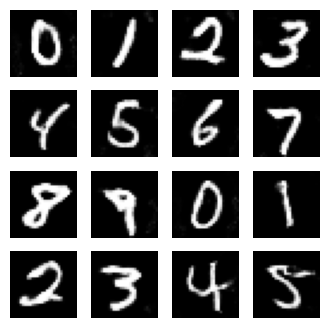

Time for epoch 370 is 10.35990309715271 sec
Time for epoch 371 is 9.829632043838501 sec
Time for epoch 372 is 9.829270124435425 sec
Time for epoch 373 is 9.858115434646606 sec
Time for epoch 374 is 9.829456806182861 sec
Time for epoch 375 is 9.784857273101807 sec
Time for epoch 376 is 9.898531436920166 sec
Time for epoch 377 is 9.816334247589111 sec
Time for epoch 378 is 9.805735111236572 sec
Time for epoch 379 is 9.802552461624146 sec


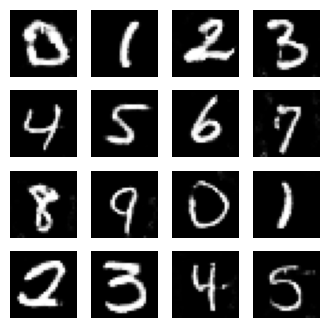

Time for epoch 380 is 10.707712888717651 sec
Time for epoch 381 is 9.835679531097412 sec
Time for epoch 382 is 9.815569877624512 sec
Time for epoch 383 is 9.864850282669067 sec
Time for epoch 384 is 9.809052467346191 sec
Time for epoch 385 is 9.831400632858276 sec
Time for epoch 386 is 9.863989114761353 sec
Time for epoch 387 is 9.816831111907959 sec
Time for epoch 388 is 9.834121227264404 sec
Time for epoch 389 is 9.858718872070312 sec


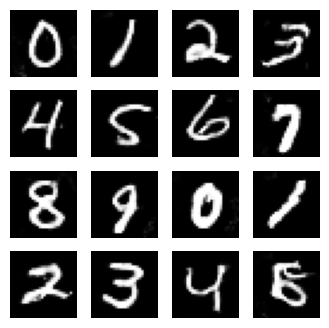

Time for epoch 390 is 10.331777572631836 sec
Time for epoch 391 is 9.822604179382324 sec
Time for epoch 392 is 9.885629415512085 sec
Time for epoch 393 is 9.83260726928711 sec
Time for epoch 394 is 9.83586072921753 sec
Time for epoch 395 is 9.82445216178894 sec
Time for epoch 396 is 9.874114513397217 sec
Time for epoch 397 is 9.808133363723755 sec
Time for epoch 398 is 9.843387126922607 sec
Time for epoch 399 is 9.851378440856934 sec


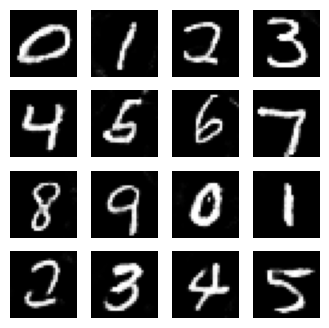

Time for epoch 400 is 10.378355264663696 sec
Time for epoch 401 is 9.805826425552368 sec
Time for epoch 402 is 9.876685857772827 sec
Time for epoch 403 is 9.814478397369385 sec
Time for epoch 404 is 9.80714201927185 sec
Time for epoch 405 is 9.867161989212036 sec
Time for epoch 406 is 9.8185875415802 sec
Time for epoch 407 is 9.815346240997314 sec
Time for epoch 408 is 9.846491813659668 sec
Time for epoch 409 is 9.833898544311523 sec


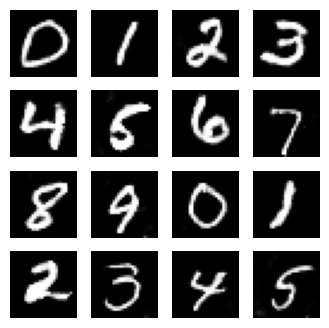

Time for epoch 410 is 10.321108341217041 sec
Time for epoch 411 is 9.827067852020264 sec
Time for epoch 412 is 9.861226558685303 sec
Time for epoch 413 is 9.82012939453125 sec
Time for epoch 414 is 9.862159490585327 sec
Time for epoch 415 is 9.858763456344604 sec
Time for epoch 416 is 9.824300289154053 sec
Time for epoch 417 is 9.807108163833618 sec
Time for epoch 418 is 9.862334489822388 sec
Time for epoch 419 is 9.819983959197998 sec


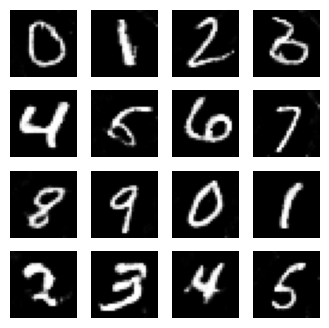

Time for epoch 420 is 10.315483808517456 sec
Time for epoch 421 is 9.85573959350586 sec
Time for epoch 422 is 9.82479476928711 sec
Time for epoch 423 is 9.823607206344604 sec
Time for epoch 424 is 9.82834506034851 sec
Time for epoch 425 is 9.83352279663086 sec
Time for epoch 426 is 9.838054418563843 sec
Time for epoch 427 is 9.815330505371094 sec
Time for epoch 428 is 9.866414546966553 sec
Time for epoch 429 is 9.798471927642822 sec


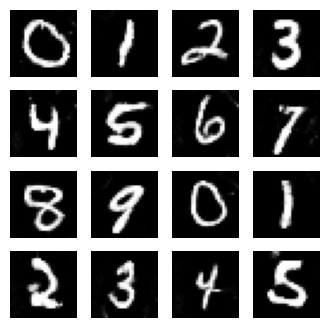

Time for epoch 430 is 10.624198913574219 sec
Time for epoch 431 is 9.874762773513794 sec
Time for epoch 432 is 9.813209772109985 sec
Time for epoch 433 is 9.825936555862427 sec
Time for epoch 434 is 9.858682632446289 sec
Time for epoch 435 is 9.837713718414307 sec
Time for epoch 436 is 9.82269549369812 sec
Time for epoch 437 is 9.833848714828491 sec
Time for epoch 438 is 9.781643390655518 sec
Time for epoch 439 is 9.830915451049805 sec


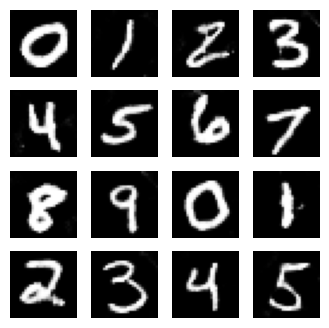

Time for epoch 440 is 10.568890571594238 sec
Time for epoch 441 is 9.792356014251709 sec
Time for epoch 442 is 9.814957857131958 sec
Time for epoch 443 is 9.79496455192566 sec
Time for epoch 444 is 9.833390712738037 sec
Time for epoch 445 is 9.796235799789429 sec
Time for epoch 446 is 9.801000595092773 sec
Time for epoch 447 is 9.788671731948853 sec
Time for epoch 448 is 9.853236675262451 sec
Time for epoch 449 is 9.80624532699585 sec


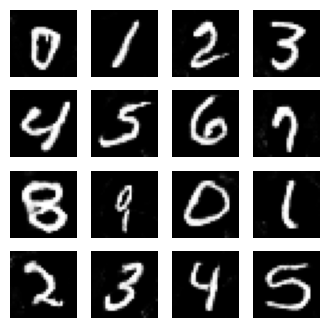

Time for epoch 450 is 10.364512920379639 sec
Time for epoch 451 is 9.832293510437012 sec
Time for epoch 452 is 9.827165603637695 sec
Time for epoch 453 is 9.857857465744019 sec
Time for epoch 454 is 9.838539600372314 sec
Time for epoch 455 is 9.810565948486328 sec
Time for epoch 456 is 9.809121131896973 sec
Time for epoch 457 is 9.857593297958374 sec
Time for epoch 458 is 9.823124408721924 sec
Time for epoch 459 is 9.804916858673096 sec


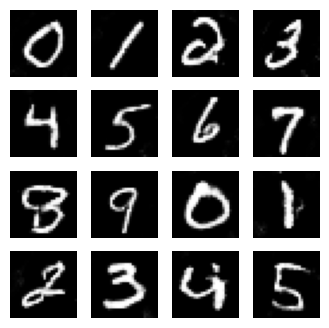

Time for epoch 460 is 10.404001474380493 sec
Time for epoch 461 is 9.813934326171875 sec
Time for epoch 462 is 9.832473039627075 sec
Time for epoch 463 is 9.834370374679565 sec
Time for epoch 464 is 9.80833649635315 sec
Time for epoch 465 is 9.804996490478516 sec
Time for epoch 466 is 9.86907172203064 sec
Time for epoch 467 is 9.833615779876709 sec
Time for epoch 468 is 9.810483694076538 sec
Time for epoch 469 is 9.847811698913574 sec


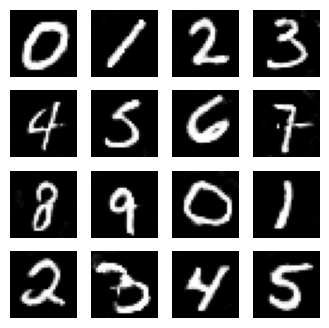

Time for epoch 470 is 10.32455563545227 sec
Time for epoch 471 is 9.828086137771606 sec
Time for epoch 472 is 9.826310157775879 sec
Time for epoch 473 is 9.872935771942139 sec
Time for epoch 474 is 9.829835176467896 sec
Time for epoch 475 is 9.79201054573059 sec
Time for epoch 476 is 9.838260889053345 sec
Time for epoch 477 is 9.814698934555054 sec
Time for epoch 478 is 9.84543490409851 sec
Time for epoch 479 is 9.853537321090698 sec


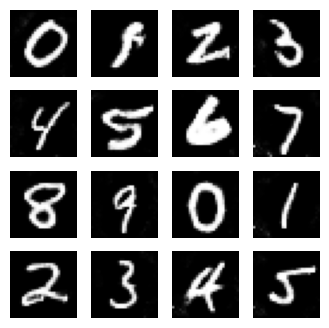

Time for epoch 480 is 10.61954379081726 sec
Time for epoch 481 is 9.808915376663208 sec
Time for epoch 482 is 9.869473457336426 sec
Time for epoch 483 is 9.83731985092163 sec
Time for epoch 484 is 9.822256326675415 sec
Time for epoch 485 is 9.863256692886353 sec
Time for epoch 486 is 9.848201036453247 sec
Time for epoch 487 is 9.824538946151733 sec
Time for epoch 488 is 9.81434679031372 sec
Time for epoch 489 is 9.875330924987793 sec


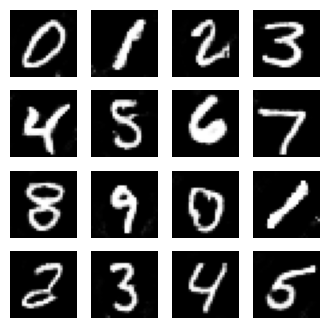

Time for epoch 490 is 10.325660467147827 sec
Time for epoch 491 is 9.861144781112671 sec
Time for epoch 492 is 9.88397765159607 sec
Time for epoch 493 is 9.845980405807495 sec
Time for epoch 494 is 9.867501020431519 sec
Time for epoch 495 is 9.924099206924438 sec
Time for epoch 496 is 9.850428104400635 sec
Time for epoch 497 is 9.857988119125366 sec
Time for epoch 498 is 9.906363010406494 sec
Time for epoch 499 is 9.852998971939087 sec


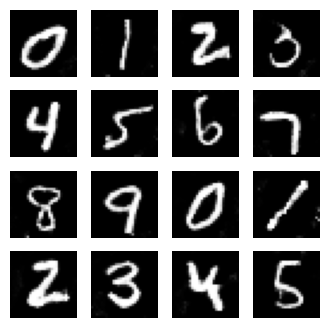

Time for epoch 500 is 10.338625431060791 sec


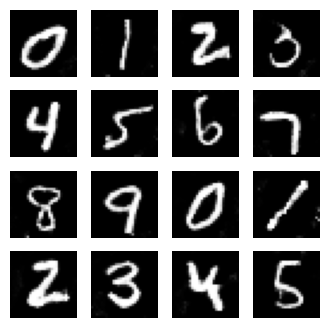

In [15]:
train(dataset, 500)

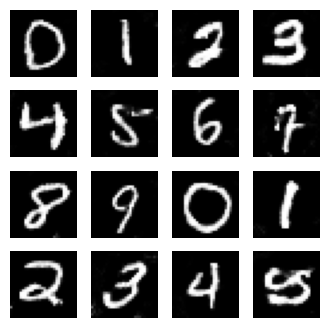

In [16]:
noise = tf.random.normal([16, LATENT_DIM])
label = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5])
generate_images(generator, 0, noise, label)

# Checkpoint

In [17]:
import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
checkpoint.save(file_prefix = checkpoint_prefix)

'./training_checkpoints/ckpt-1'